***
### Import of required libraries
***

In [ ]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from geopy.distance import distance

from traffic.core import Traffic
from tqdm.auto import tqdm

***
### Import of data, model and scalers
***

##### Trajectory data

In [ ]:
t = Traffic.from_file(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/t_test.parquet"
)

##### Model

In [ ]:
def rmse_lat():
    return None


def rmse_lon():
    return None


def rmse_alt():
    return None


model = load_model(
    f"/home/krum/git/MT_krum_code/models/snowy-gorge-126.keras",
    custom_objects={
        "rmse_lat": rmse_lat,
        "rmse_lon": rmse_lon,
        "rmse_alt": rmse_alt,
        "weighted_mse": tf.keras.losses.MeanSquaredError(),
    },
)

##### Scalers

In [ ]:
# scaler_in
with open(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/scaler_in.pkl",
    "rb",
) as file:
    scaler_in = pickle.load(file)

# scaler_out
with open(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/scaler_out.pkl",
    "rb",
) as file:
    scaler_out = pickle.load(file)

***
### First try (not working)
***

In [251]:
def calculate_distance(row1, row2):
    coords_1 = (row1["latitude"], row1["longitude"])
    coords_2 = (row2["latitude"], row2["longitude"])
    return distance(coords_1, coords_2).meters

In [311]:
flight.data[
    [
        "latitude",
        "longitude",
        "altitude",
    ]
].iloc[0:10]

,latitude,longitude,altitude
44930789,47.456691,8.569388,1125.0
44930793,47.456691,8.569157,1125.0
44930796,47.456715,8.568861,1125.0
44930798,47.456761,8.568554,1125.0
44930802,47.456782,8.568282,1125.0
44930803,47.456807,8.567777,1125.0
44930807,47.456842,8.567416,1125.0
44930809,47.456885,8.566920,1125.0
44930814,47.456908,8.566518,1125.0
44930816,47.456943,8.565864,1125.0


In [324]:
actual_to_dist_m = []
pred_to_dist_m = []

for flight in tqdm(t[0:100]):
    # Actual take-off distance
    flightdata = flight.cumulative_distance().data
    flightdata["cumdist_m"] = flightdata["cumdist"] * 1852
    runalt_m = ((flightdata[0:10].altitude) / 3.281).mean()
    flightdata["agl_m"] = (flightdata.altitude / 3.281) - runalt_m
    flightdata["status"] = np.where(flightdata["agl_m"] <= 20, "ground", "air")
    to_dist_m = round(
        flightdata[flightdata["status"] == "ground"]["cumdist_m"].iloc[-1]
    )
    actual_to_dist_m.append(to_dist_m)

    # Predicted
    f_in_var_unscaled = flight.data[
        [
            "latitude",
            "longitude",
            "altitude",
        ]
    ].iloc[0:10]

    input_var = (
        flight.data[
            [
                "latitude_scaled",
                "longitude_scaled",
                "altitude_scaled",
                "wind_x_2min_avg_scaled",
                "wind_y_2min_avg_scaled",
                "temperature_gnd_scaled",
                "humidity_gnd_scaled",
                "pressure_gnd_scaled",
            ]
        ]
        .iloc[0:10]
        .to_numpy()
        .reshape(1, 10, 8)
    )

    input_con = (
        flight.data[
            [
                "toff_weight_kg_scaled",
                "typecode_A20N",
                "typecode_A21N",
                "typecode_A319",
                "typecode_A320",
                "typecode_A321",
                "typecode_A333",
                "typecode_A343",
                "typecode_B77W",
                "typecode_BCS1",
                "typecode_BCS3",
                "typecode_CRJ9",
                "typecode_DH8D",
                "typecode_E190",
                "typecode_E195",
                "typecode_E290",
                "typecode_E295",
                "typecode_F100",
                "typecode_SB20",
                "SID_DEGES",
                "SID_GERSA",
                "SID_VEBIT",
                "SID_ZUE",
                "hour_sin",
                "hour_cos",
                "weekday_sin",
                "weekday_cos",
                "month_sin",
                "month_cos",
            ]
        ]
        .iloc[10]
        .to_numpy()
        .reshape(1, 1, 29)
    )

    output = model.predict((input_var, input_con), verbose=0)
    output_unscaled = scaler_out.inverse_transform(
        output.reshape(-1, 3)
    ).reshape(37, 3)[1:, :]

    df_in = f_in_var_unscaled
    df_out = pd.DataFrame(
        output_unscaled, columns=["latitude", "longitude", "altitude"]
    )
    df = pd.concat([df_in, df_out]).reset_index(drop=True)
    df["agl_m"] = (df.altitude / 3.281) - runalt_m

    # Calculate travelled distance and add to new column
    dist_diff = df.apply(
        lambda row: (
            calculate_distance(df.loc[row.name - 1], row)
            if row.name > 0
            else 0
        ),
        axis=1,
    )

    df["cumdist"] = dist_diff.cumsum()

    to_dist_pred = round(df[df["agl_m"] <= 20]["cumdist"].iloc[-1])
    pred_to_dist_m.append(to_dist_pred)

100%|██████████| 100/100 [00:06<00:00, 14.48it/s]


In [332]:
# Convert lists to Pandas Series
pred_to_dist_m_series = pd.Series(pred_to_dist_m, name="Predicted")
actual_to_dist_m_series = pd.Series(actual_to_dist_m, name="Actual")

# Calculate the error directly
error_series = pred_to_dist_m_series - actual_to_dist_m_series

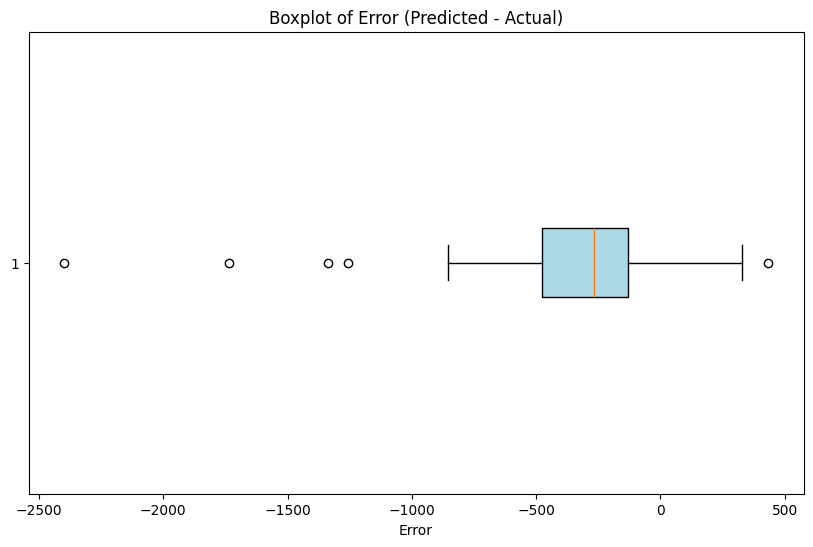

In [335]:
# Plot a boxplot of the error series
plt.figure(figsize=(10, 6))
plt.boxplot(
    error_series,
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
)
plt.title("Boxplot of Error (Predicted - Actual)")
plt.xlabel("Error")

# Display the plot
plt.show()

Idea multiple boxplot by aircraft type or weight category

***
### Visualisation
***

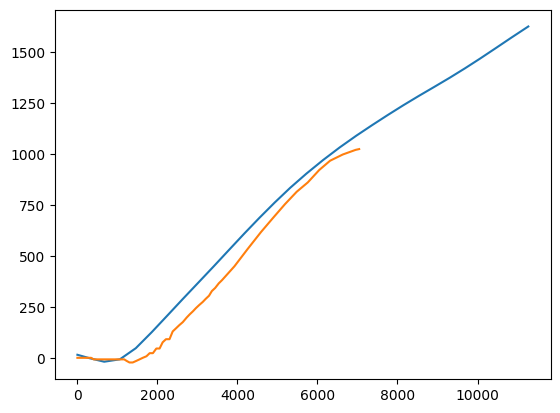

In [290]:
plt.plot(df["cumdist"][0:30], df["agl_m"][0:30], label="Predicted")
plt.plot(
    flightdata["cumdist"][0:100] * 1852,
    flightdata["agl_m"][0:100],
    label="Actual",
)